# EDA - Info and Route

TODOs
- Fix errors
- ...

> [Notebook](https://www.kaggle.com/mbnb8317/ds4c-tutorial-all-about-folium) by Yeonjun IN


In [1]:
# Mount for Colab (Optional)
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    DATASET_BASE = '/content/drive/My Drive/CovidApps/datasets/'
else:
    DATASET_BASE = '../datasets/'

DS4C_PATH = DATASET_BASE + 'coronavirusdataset/'

In [2]:
import numpy as np
import pandas as pd
        
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
from folium import plugins

import json 
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#### Read CSV

In [3]:
patient = pd.read_csv(DS4C_PATH + 'PatientInfo.csv')
route = pd.read_csv(DS4C_PATH + 'PatientRoute.csv')

In [4]:
patient.tail()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
3514,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,2020-04-21,NaN,released
3515,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated
3516,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,9.0,NaN,2020-04-03,2020-05-05,NaN,released
3517,7000000013,NaN,female,NaN,10s,China,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,6.0,NaN,2020-04-14,2020-04-26,NaN,released
3518,7000000014,NaN,female,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,Itaewon Clubs,NaN,NaN,NaN,NaN,2020-05-09,NaN,NaN,isolated


In [5]:
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534


## Patient Data 

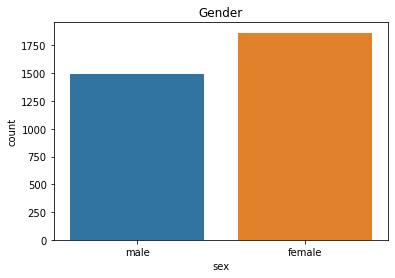

In [6]:
sns.countplot(patient['sex'])
plt.title('Gender')
plt.show()

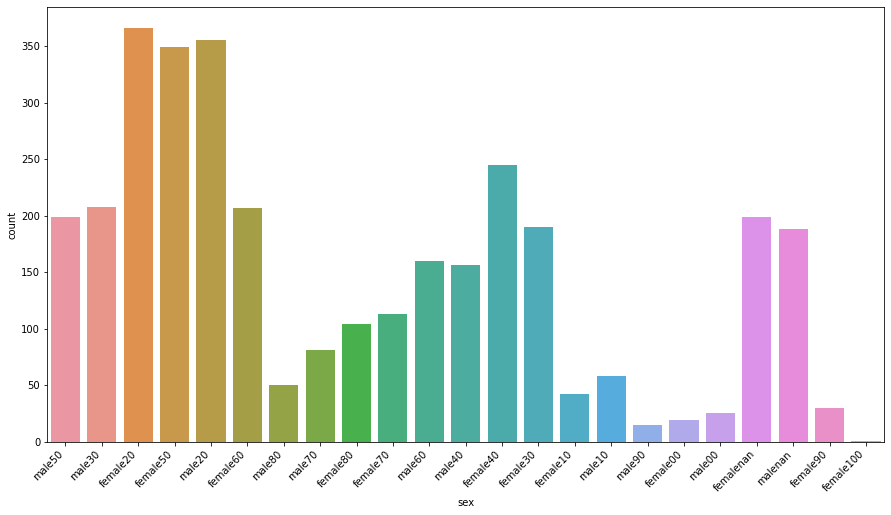

In [7]:
patient['age'] = 2020 - patient['birth_year'] + 1
patient['age_group'] = patient['age'] // 10
patient['age_group'] = [str(a).replace('.','') for a in patient['age_group']]

plt.figure(figsize = (15,8))
ax = sns.countplot(patient['sex'].str.cat(patient['age_group']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

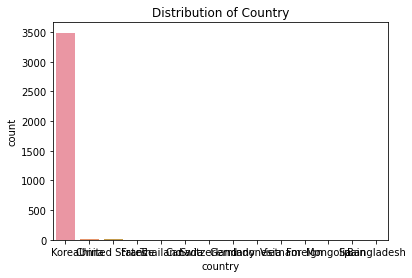

In [8]:
sns.countplot(patient['country'])
plt.title('Distribution of Country')
plt.show()

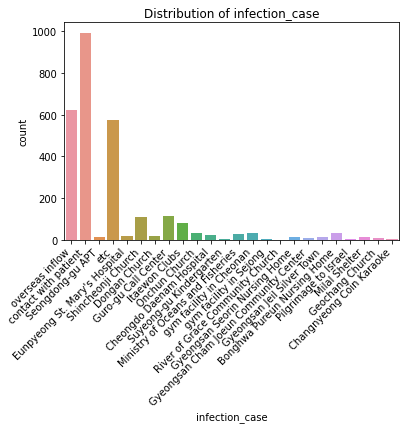

In [9]:
ax = sns.countplot(patient['infection_case'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of infection_case')
plt.show()

As you can see Capital area, Daegu, and Gyeongsangbuk-do rank top 3.


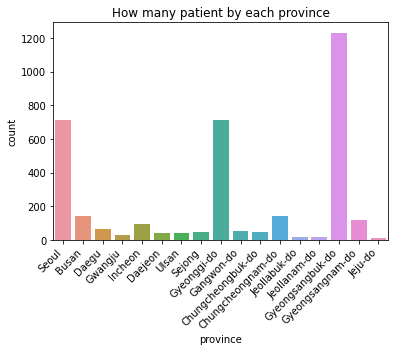

In [10]:
print('As you can see Capital area, Daegu, and Gyeongsangbuk-do rank top 3.')
ax = sns.countplot(patient['province'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('How many patient by each province')
plt.show()

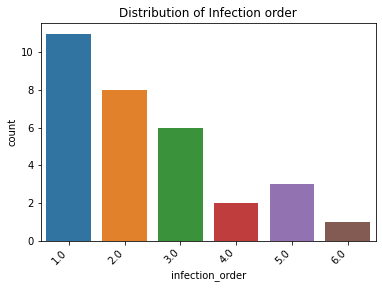

In [11]:
ax = sns.countplot(patient['infection_order'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of Infection order')
plt.show()

In my opinion, there seems to be 7 anomalies points, which locate above the red line.
They might have a important role on spread of CVD 19.
Lets take a look at those.


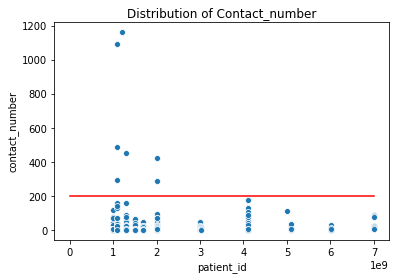

In [12]:
print('In my opinion, there seems to be 7 anomalies points, which locate above the red line.')
print('They might have a important role on spread of CVD 19.')
print('Lets take a look at those.')
sns.scatterplot(patient['patient_id'],patient['contact_number'])
plt.plot([0,7000000000], [200,200], color = 'red')
plt.title('Distribution of Contact_number')
plt.show()

In [13]:
anomaly_id = patient.query('contact_number > 200')['patient_id'].values; display(anomaly_id)

array([1100000001, 1100000007, 1100000012, 1200000031, 1300000001,
       2000000003, 2000000006])

## Let's make geospatial plot

- to see where the anomalies went

In [14]:
def make_polygon(route_df, patient_df, id_num):
    
    id_filter = route_df.query('patient_id == @id_num')
    id_filter['timestamp'] = [json.dumps(date+'T00:00:00') for date in id_filter['date']]
    
    ctc = int(patient_df.query('patient_id == @id_num')['contact_number'].values[0])
    
    print(f'{id_num}th patient made contacts with {ctc} in those path')
    
    id_filter_shift = id_filter.shift(-1) 

    # set the zoom point
    m = folium.Map([37, 128], zoom_start=7)

    # set the icon on Incheon airport and gimpo airport
    icon_plane1 = plugins.BeautifyIcon( icon='plane', border_color='#b3334f', text_color='#b3334f', icon_shape='triangle')
    icon_plane2 = plugins.BeautifyIcon( icon='plane', border_color='#b3334f', text_color='#b3334f', icon_shape='triangle')

    folium.Marker( location=[37.4692, 126.451], popup='incheon airport', icon=icon_plane1).add_to(m)
    folium.Marker( location=[37.558808, 126.794458], popup='gimpo airport', icon=icon_plane2 ).add_to(m)

    # add the fullscreen utility. if you don't need, it's ok to remark the line :)
    plugins.Fullscreen( position='topright', title='Click to expand', title_cancel='Click to exit', force_separate_button=True ).add_to(m)

    folium.Polygon( locations = id_filter[['latitude','longitude']], fill = True, tooltip = 'Polygon' ).add_to(m) 
    
    for lat,lon in zip(id_filter.latitude, id_filter.longitude): 
        folium.Circle( location = [lat,lon], 
                      radius = 400,
                     color = 'red').add_to(m)
    
    return m

TODO FIXME

In [15]:
make_polygon(route, patient, 1200000031)

1200000031th patient made contacts with 1160 in those path


In [16]:
make_polygon(route, patient, 1300000001)

1300000001th patient made contacts with 450 in those path


In [17]:
make_polygon(route, patient, 2000000003)

2000000003th patient made contacts with 422 in those path


ValueError: Locations is empty.

In [18]:
make_polygon(route, patient, 2000000006)

2000000006th patient made contacts with 290 in those path


## Let't do it with time variable

In [19]:
def make_polygon_time(route_df, patient_df, id_num):
    print(f'Where {id_num}th patient went for several days')
    
    
    # set the zoom point
    m = folium.Map([37, 128], zoom_start=7)
    
    id_filter = route_df.query('patient_id == @id_num')
    id_filter['timestamp'] = [date+'T00:00:00' for date in id_filter['date']]
    id_filter_shift = id_filter.shift(-1) 
    
    # set the icon on Incheon airport and gimpo airport
    icon_plane1 = plugins.BeautifyIcon( icon='plane', border_color='#b3334f', text_color='#b3334f', icon_shape='triangle')
    icon_plane2 = plugins.BeautifyIcon( icon='plane', border_color='#b3334f', text_color='#b3334f', icon_shape='triangle')

    folium.Marker( location=[37.4692, 126.451], popup='incheon airport', icon=icon_plane1 ).add_to(m)
    folium.Marker( location=[37.558808, 126.794458], popup='gimpo airport', icon=icon_plane2 ).add_to(m)
    
    # add the fullscreen utility. if you don't need, it's ok to remark the line :)
    plugins.Fullscreen( position='topright', title='Click to expand', title_cancel='Click to exit', force_separate_button=True ).add_to(m)

    
    lines = []
    for lon, lat, time, lon_s, lat_s, time_s in zip(id_filter['longitude'], id_filter['latitude'], id_filter['timestamp'], 
                                                    id_filter_shift['longitude'], id_filter_shift['latitude'], id_filter_shift['timestamp']):
        temp_dict = {}
        temp_dict['coordinates'] = [[lon,lat], [lon_s,lat_s]]
        temp_dict['dates'] = [time,time_s]
        temp_dict['color'] = 'red'

        lines += [temp_dict]

    del lines[-1]

    features = [ { 'type': 'Feature', 
                  'geometry': { 'type': 'LineString', 
                               'coordinates': line['coordinates'], }, 
                  'properties': { 'times': line['dates'], 
                                 'style': { 'color': line['color'], 
                                           'weight': line['weight'] if 'weight' in line else 5 } } } for line in lines ] 

    plugins.TimestampedGeoJson({ 'type': 'FeatureCollection', 'features': features, }, period='P1D', add_last_point=True).add_to(m) 

    return m

In [20]:
make_polygon_time(route, patient, 1200000031)

Where 1200000031th patient went for several days


In [21]:
make_polygon_time(route, patient, 1300000001)

Where 1300000001th patient went for several days


In [22]:
make_polygon_time(route, patient, 2000000003)

Where 2000000003th patient went for several days


IndexError: list assignment index out of range

In [23]:
make_polygon_time(route, patient, 2000000006)

Where 2000000006th patient went for several days


# What i discover
- If you remember how many patients by each region, capital area, Daegu, and Gyeongsangbuk-do rank top 3.
- As you can see in geospatial plot, almost anomalies went capital area, Daegu.
- I have gotten a kind of suspicion about the impact of anomalies on spread of CVD-19

## Thank you for attention :) 